# CATCH ME IF YOU CAN - a social network analysis

## Introduction
Wagwan

## Group Members:

- **[289791]**: Eliya Allam

- **[283791]**: Mattia Cervelli

- **[286881]**: Davide Pisano
  
- **[287611]**: Giulio Presaghi

- **[283361]**: Marco Tagliavini

## Project Overview:
**[WEEK 1](#week1)** -- Understanding the network we are dealing with

**[WEEK 2](#week2)** -- Insights into local connectivity and overall cohesiveness.

**[WEEK 3](#week3)** -- Dealing with the centralities

**[WEEK 5](#week5)** --  Page Rank implementation and cumulative distribution

**[WEEK 6](#week6)** --  

**[WEEK 7](#week7)** --  

## Tools and Technologies Used:

- **Programming Language**: Python
- **Libraries**: Pandas, NumPy, Matplotlib, NetworkX, JSON, HeapQ, community
- **Platform**: Jupyter Notebook

**LIBRARIES WE ARE GOING TO USE:**

In [4]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import json
import heapq
import numpy as np
import community
import time
import random

<a id="week1"></a>

**OPENING THE FILE:**


In [5]:
nodes_df = pd.read_csv("C:\\Users\\david\\OneDrive\\Desktop\\sna_dataset\\nodes.csv")
edges_df = pd.read_csv("C:\\Users\\david\\OneDrive\\Desktop\\sna_dataset\\edges.csv")

The following line takes the *' viz'* column of the *nodes_df* DataFrame and performs two operations:

First, it replaces all single quotes (') with double quotes (") to make the string JSON-compatible.
Then, it parses the modified string as a JSON object, converting it into a *Python dictionary*.

In [6]:
nodes_df[' viz'] = nodes_df[' viz'].apply(lambda row: row.replace("'", '"')).apply(json.loads)

This section initializes an empty undirected graph G. It then iterates over the rows of nodes_df to add nodes to the graph, and over the rows of edges_df to add edges. Each node and edge is added with its associated attributes.

In [7]:
G = nx.Graph()

for index, row in nodes_df.iterrows():
    G.add_node(row['# index'], label=row[' label'], viz=row[' viz'])
for index, row in edges_df.iterrows():
    G.add_edge(row['# source'], row[' target'], label=row[' label'], weight=row[' weight'])

positions = {node: (data['viz']['position']['x'], data['viz']['position']['y']) for node, data in G.nodes(data=True)}
colors = [(data['viz']['color']['r']/255, data['viz']['color']['g']/255, data['viz']['color']['b']/255, data['viz']['color']['a']) for node, data in G.nodes(data=True)]
sizes = [data['viz']['size'] * 100 for node, data in G.nodes(data=True)]

*Graph G* is now ready to be visualized.

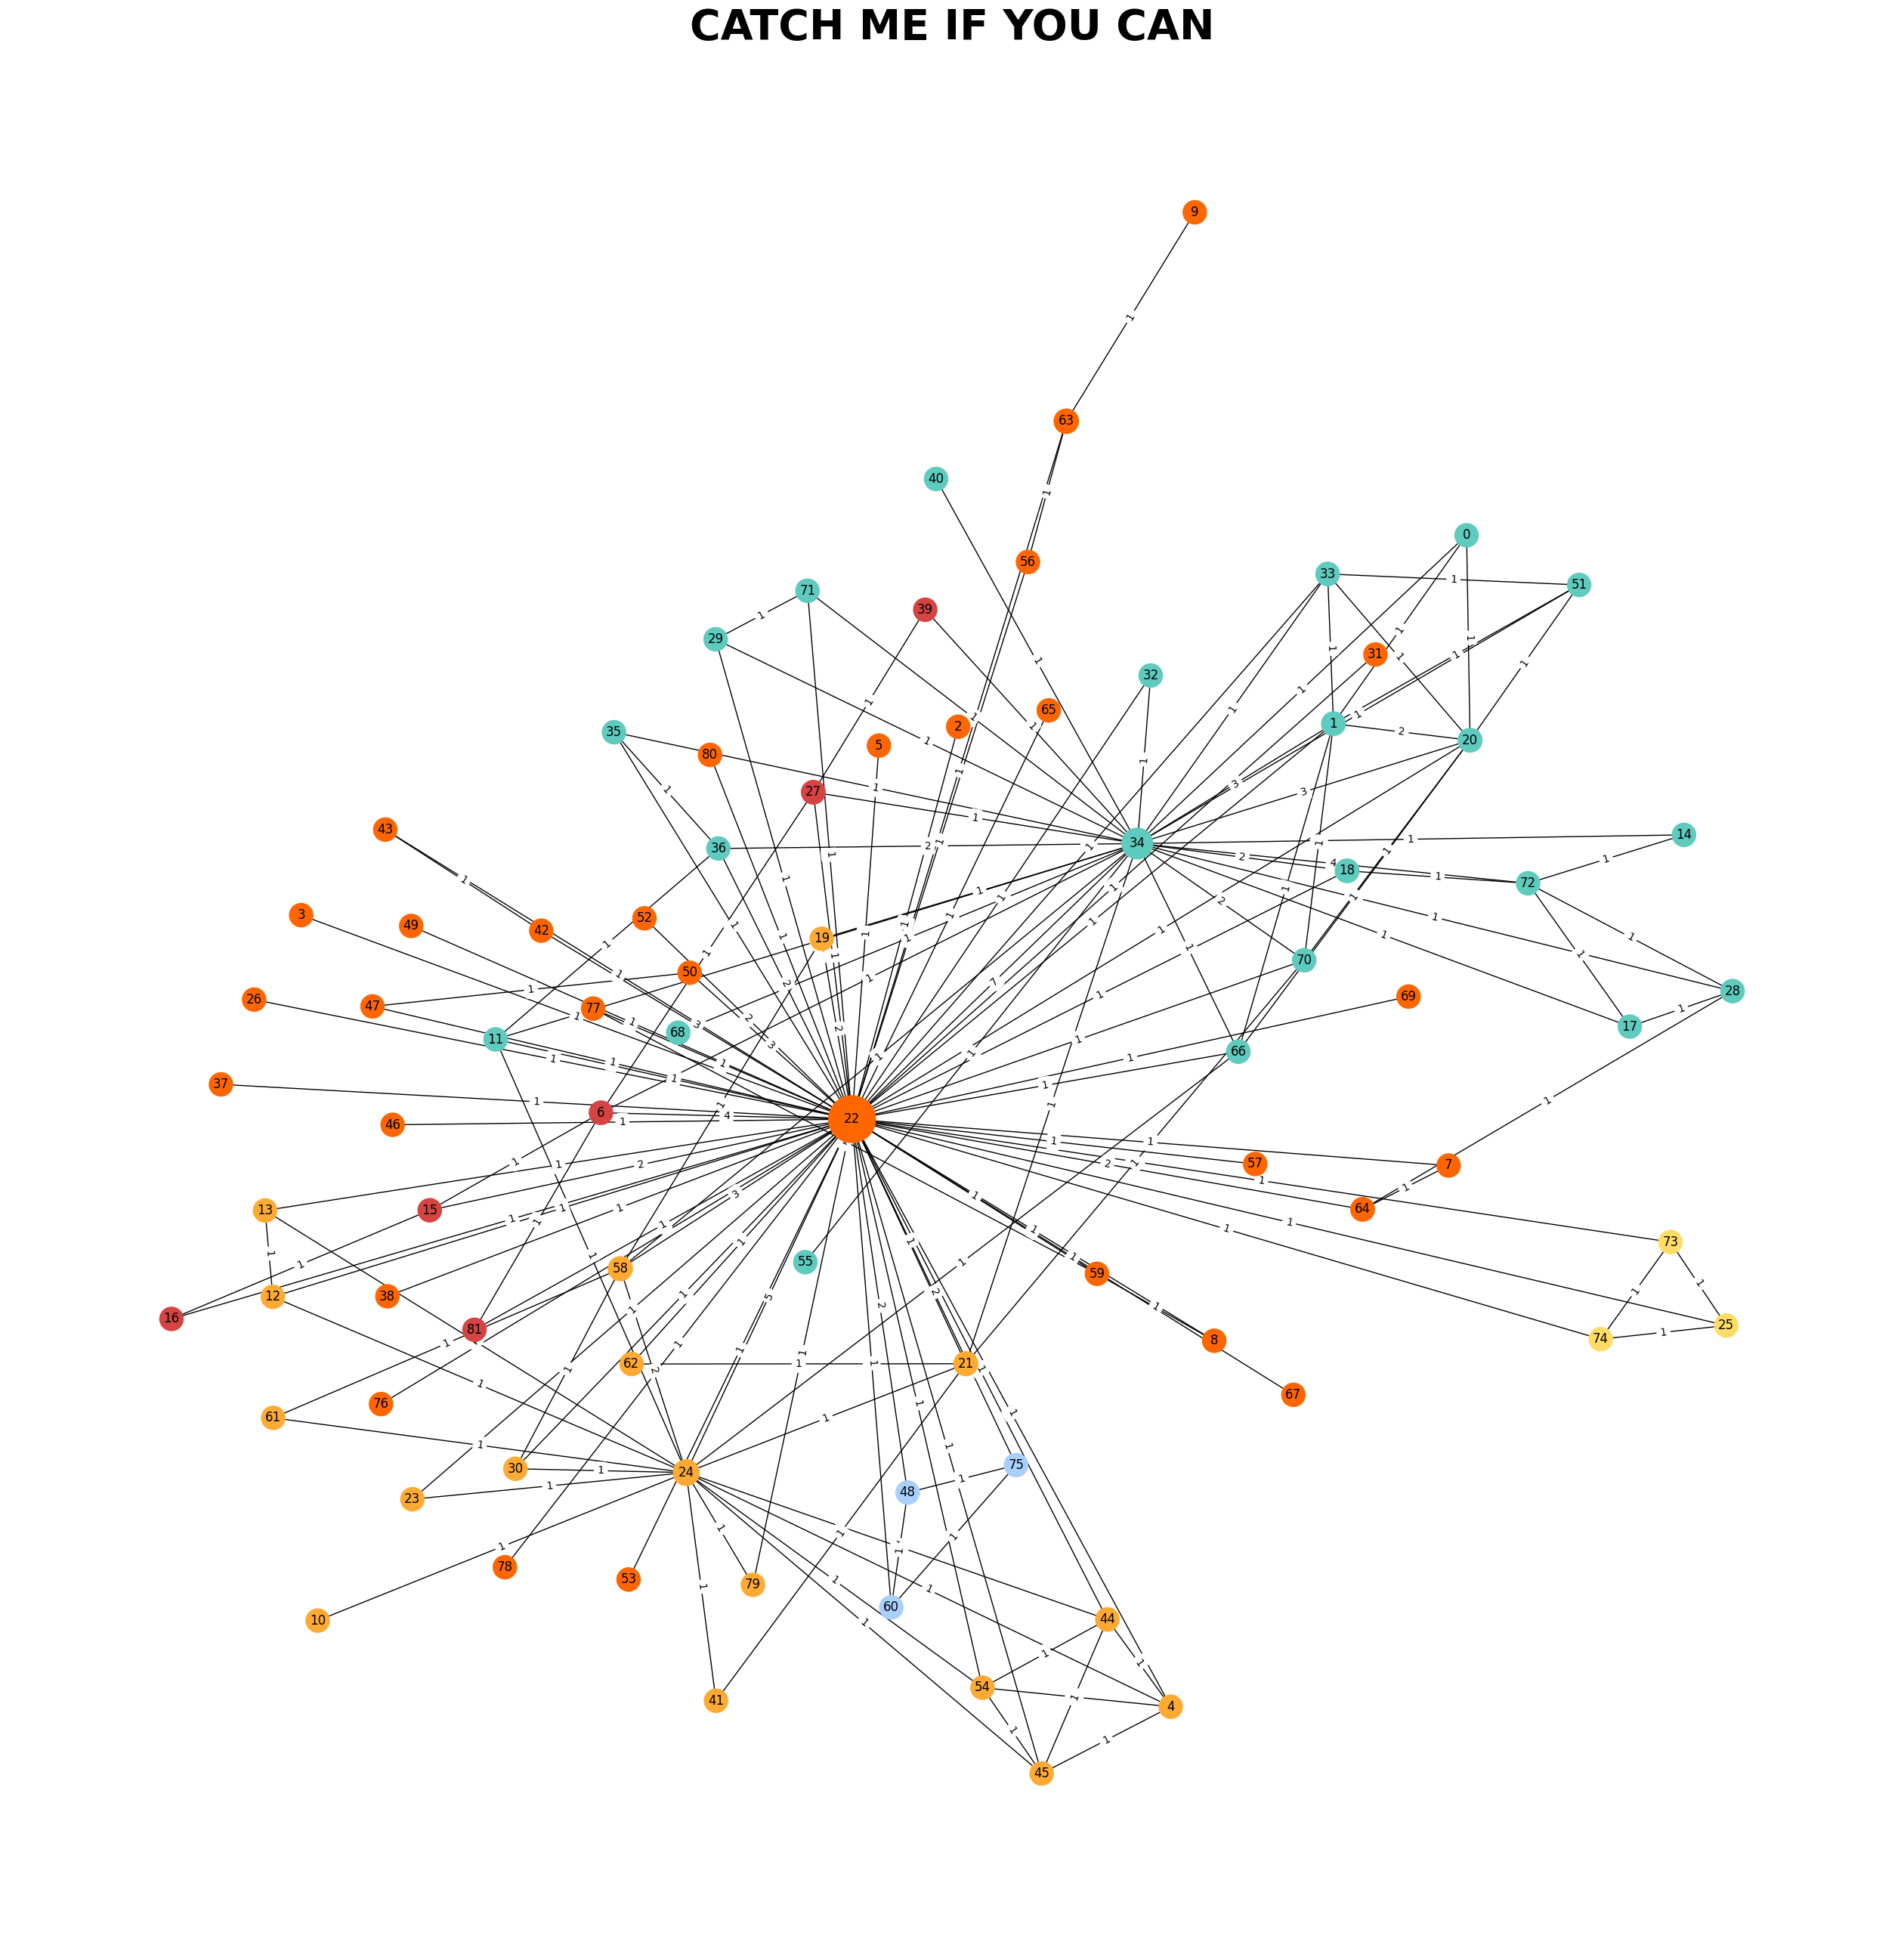

In [8]:

plt.figure(figsize=(25, 25))
nx.draw(G, pos=positions, node_color=colors, node_size=sizes, with_labels=True)
edge_labels = {(u, v): d['weight'] for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos=positions, edge_labels=edge_labels)
plt.title('CATCH ME IF YOU CAN', size=40, weight='bold')
plt.show()


NUMBER OF NODES, NUMBER OF EDGES, AVERAGE DEGREE AND THE DENSITY

In [9]:
n = G.number_of_nodes()
m = G.number_of_edges()
print("Number of nodes: ", n)
print("Number of edges: ", m)

Number of nodes:  82
Number of edges:  162


the degree k(v)
of a node v is computed by iterating over each edge in the edges_df dataframe
and incrementing the degree count for both the source and target nodes.
Given an edge \((u, v)\) from the dataframe `edges_df`:
$$
k(u) = k(u) + 1
$$
$$
k(v) = k(v) + 1
$$
where \( k(u) \) and \( k(v) \) are the degrees of nodes \( u \) and \( v \) respectively.






The average degree
⟨k⟩ is computed by summing up the degrees of all nodes and dividing by the total number of nodes.
$$
\langle k \rangle = \frac{\sum_{v \in V} k(v)}{N}
$$
where \( N \) is the total number of nodes in the graph and \( k(v) \) is the degree of node \( v \).


In [10]:
def compute_degrees(edges_df):
    degrees = {}

    for index, row in edges_df.iterrows():
        source = row['# source']
        target = row[' target']

        degrees[source] = degrees.get(source, 0) + 1
        degrees[target] = degrees.get(target, 0) + 1

    return degrees

def compute_average_degree(edges_df):
    degrees = compute_degrees(edges_df)
    total_degree = sum(degrees.values())
    N = len(degrees)

    return total_degree / N


In [11]:
print("Average degree: ", compute_average_degree(edges_df))

Average degree:  3.951219512195122


The formula for the density \( D \) of an undirected graph is:

$$
D = \frac{2M}{N(N-1)}
$$

Where:
- \( M \) is the number of edges in the graph.
- \( N \) is the number of nodes in the graph.


In [12]:
def density(G):
    n = len(G.nodes())
    m = len(G.edges())
    if n == 0 or n == 1:
        return 0.0
    density = (2 * m) / (n * (n - 1))

    return density
print('Density:', density(G))

Density: 0.04878048780487805


<a id='week2'></a>
**WEEK 2 ANALYSIS** -

While considering the largest component of your network. Depending on what you prefer/seems
more relevant in your graph

**- Compute Average clustering and Transitivity number**

**- Implement a function computing the transitivity using basic function of networkx**

DIJKSTRA’S ALGORITHM

In [13]:
def dijkstra_generic(G, start_node, use_weights=True):
    distances = {node: float('inf') for node in G.nodes()}
    distances[start_node] = 0
    pq = [(0, start_node)]
    while pq:
        current_distance, current_node = heapq.heappop(pq)
        for neighbor, edge_attr in G[current_node].items():
            weight = edge_attr['weight'] if use_weights else 1
            new_distance = current_distance + 1/weight
            if new_distance < distances[neighbor]:
                distances[neighbor] = new_distance
                heapq.heappush(pq, (new_distance, neighbor))
    return distances
all_unweighted_shortest_path_lengths = {node: dijkstra_generic(G, node, use_weights=False)
                                        for node in G.nodes()}
all_weighted_shortest_path_lengths = {node: dijkstra_generic(G, node, use_weights=True)
                                      for node in G.nodes()}


Given the nature of the data (same-scene appearances), the average clustering and transitivity seemed be more relevant to us. These metrics would provide a clearer picture of character interactions and how characters are grouped or clustered in the narrative. It would highlight which characters frequently share scenes and are thus likely central to the movie's main plot or subplots.

We, thus, implemented a first function which retrieves the number of triangles in the graph. This is done by iterating over each node in the graph and counting the number of triangles that the node is part of. The number of triangles is then divided by the number of connected triples in the graph to get the transitivity.

**TRIANGLES** -
$$
\{u, v, w\} \text{ forms a triangle if } (u, v), (v, w), \text{ and } (u, w) \text{ are edges in the graph}
$$

**TRANSITIVITY** -
$$
T = \frac{3 \times \text{triangles\_count}}{\text{wedges}}
$$
Where:
'TRIANGLES COUNT' is the number of unique triangles in the graph and
'WEDGES' is the sum of the number of pairs of neighbors for each node in the graph.


In [14]:
def count_triangles(G, node):
    neighbors = set(G.neighbors(node))
    count = 0
    for u in neighbors:
        for v in neighbors:
            if u != v and G.has_edge(u, v):
                count += 1
    return count // 2  # Each triangle is counted twice for each node

def total_triangles(G):
    triangle_count = 0
    for node in G.nodes():
        triangle_count += count_triangles(G, node)
    return triangle_count // 3  # Each triangle is counted three times


triangles_in_graph = total_triangles(G)
def custom_transitivity_from_triangles(G, triangle_count):
    triples = sum(len(list(nx.ego_graph(G, v))) * (len(list(nx.ego_graph(G, v))) - 1) for v in G) / 2
    if triples == 0:
        return 0
    return (3 * triangle_count) / triples
custom_trans_from_triangles = custom_transitivity_from_triangles(G, triangles_in_graph)


We then implemented a second function which computes the average clustering coefficient of the graph. This is done by iterating over each node in the graph and computing the clustering coefficient of the node.

**Clustering Coefficient for a Node**:
For a given node \( v \) with degree \( k \):
$$
C(v) = \frac{2T(v)}{k(k-1)}
$$
Where \( T(v) \) is the number of triangles involving node \( v \).

The clustering coefficient of the node is then added to the total clustering coefficient of the graph. The total clustering coefficient is then divided by the number of nodes in the graph to get the average clustering coefficient.

**Average Clustering Coefficient**:
For the entire graph \( G \):
$$
C = \frac{1}{n} \sum_{v \in V} C(v)
$$
Where \( n \) is the number of nodes in \( G \) and \( V \) is the set of nodes.

In [15]:
def avg_clustering(G):
    total_clustering_coeff = 0
    for node in G.nodes():
        k = len(list(G.neighbors(node)))
        if k < 2:
            continue
        
        T = count_triangles(G, node)
        local_clustering_coeff = (2 * T) / (k * (k - 1))
        total_clustering_coeff += local_clustering_coeff
    
    return total_clustering_coeff / len(G.nodes())





avg_clustering_custom = avg_clustering(G)
avg_clustering_custom


0.5990508780501608

<a id='week3'></a>
**WEEK 3 ANALYSIS** -

Depending on what seems more relevant in your graph, pick one of the following local notions

- *Decay centrality*
  
- *Betweeness centrality*
  
- *Closeness centrality*
  
- *Clustering*
  
- *Any other notions that you invent*
  
**1) Provide a code computing the given centrality using basic functions of networkx (you are not allowed to use directly nx."what you want").**

**2) Discuss why you picked this measure and who is the most central in your network based on your  choice.**

**3) Provide the cumulative distribution for this centrality and give a graphical representation of your graph(log-log, log or normal representation as you think it is more relevant).**

**CLOSENESS CENTRALITY**
could be a relevant approach in our analysis. It would allow us to identify the characters who are most central to the narrative. These characters would be the ones who are most likely to be involved in the main plot or subplots of the movie.

Therefore, given the following formula for the **Closeness Centrality**:

$$ C(u) = \frac{n - 1}{\sum_{v \neq u} d(v, u)} $$

This is the corresponding implementation:

In [16]:
def custom_closeness_centrality(G, all_unweighted_shortest_path_lengths):
    closeness_centrality = {}
    N = len(G.nodes)

    for u in G.nodes:
        sp_length = all_unweighted_shortest_path_lengths[u]
        n = len(sp_length)
        closeness_centrality[u] = (n - 1) / (N - 1) if n != 1 else 0.0
        closeness_centrality[u] /= sum(sp_length.values()) if n != 1 else 1.0

    return closeness_centrality
all_unweighted_shortest_path_lengths = {node: dijkstra_generic(G, node, use_weights=False) for node in G.nodes()}

closeness_centrality_custom = custom_closeness_centrality(G, all_unweighted_shortest_path_lengths)
most_central_character = max(closeness_centrality_custom, key=closeness_centrality_custom.get)

print('Most central character:', most_central_character)
print('Closeness centrality:', closeness_centrality_custom[most_central_character])


Most central character: 22
Closeness centrality: 0.010526315789473684


It results that our protagonist (node 22) has relatively low closeness centrality, shich suggest that the character is not closely connected to many other characters in the movie, indicating a potential narrative focus on isolated or introspective journeys, distinct subplots or a fragmented narrative.

**DISPLAYING THE CLOSENESS CENTRALITY FOR EACH NODE**

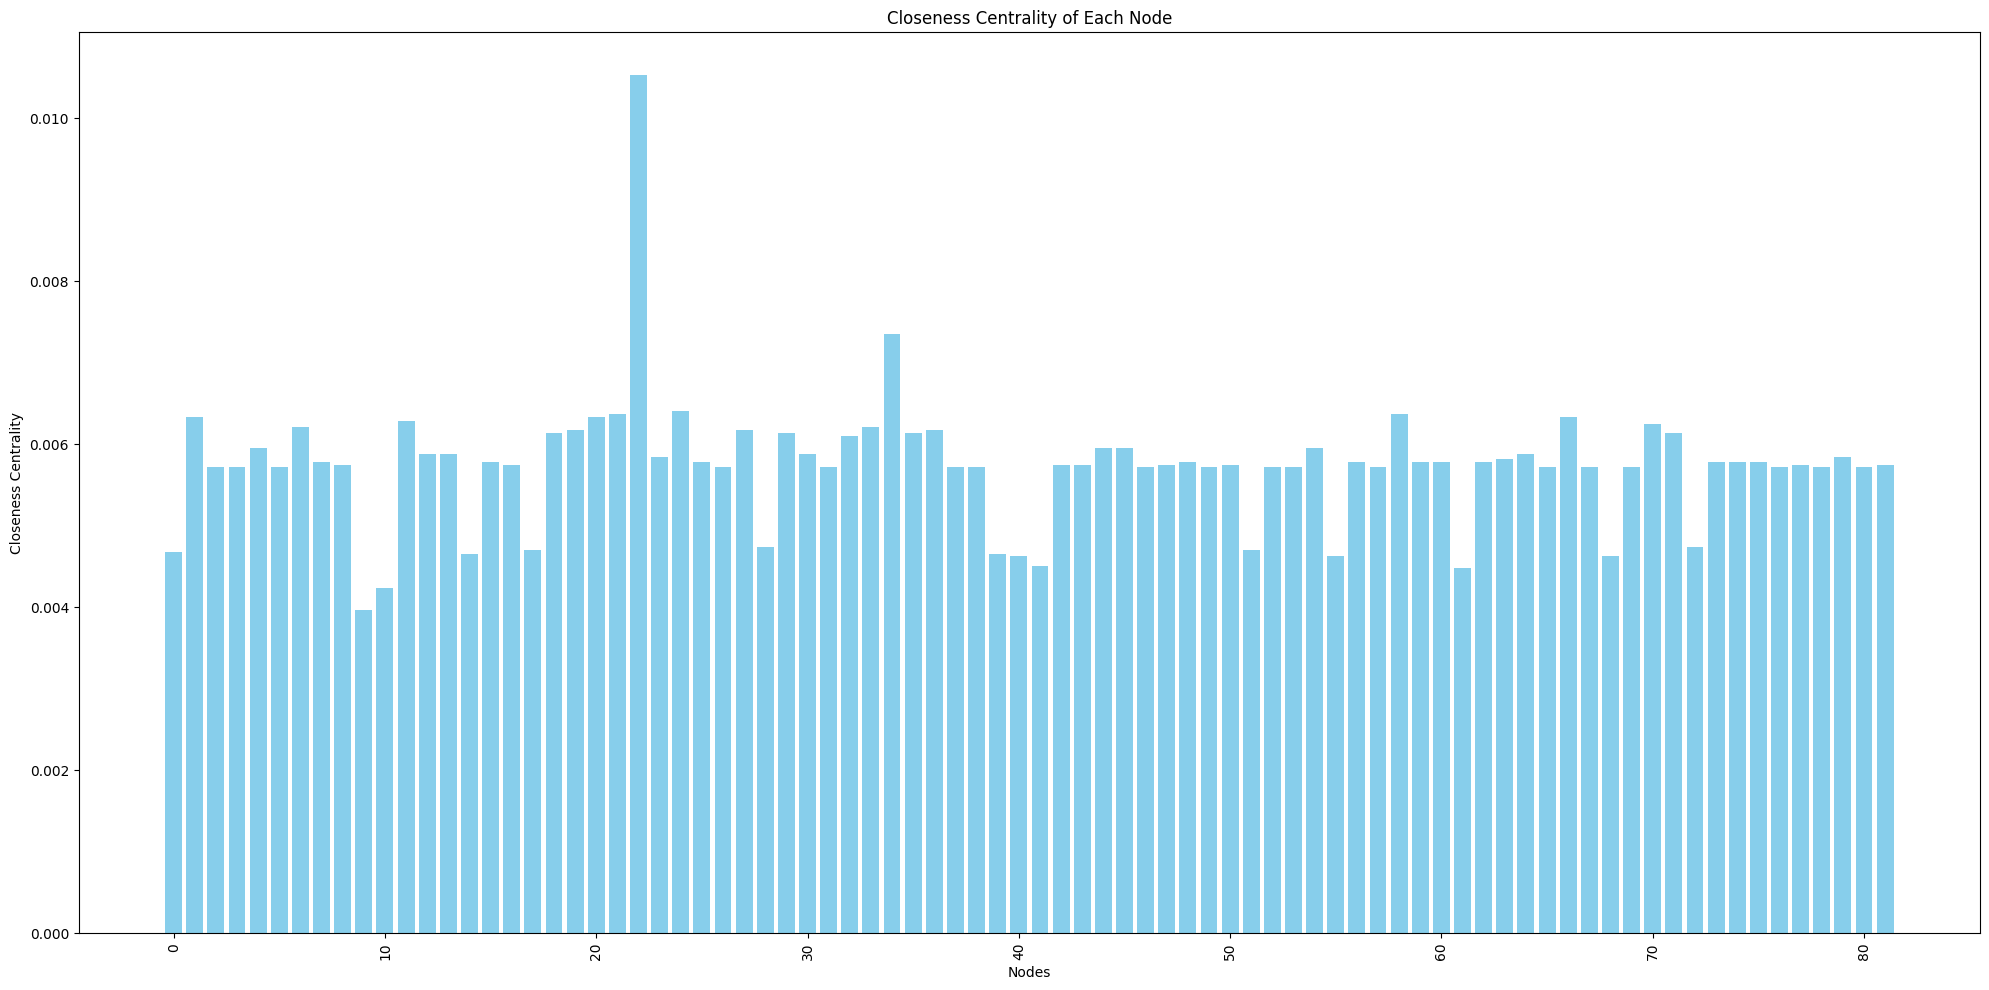

In [17]:
nodes = list(closeness_centrality_custom.keys())
closeness_values = list(closeness_centrality_custom.values())

plt.figure(figsize=(20,10))
plt.bar(nodes, closeness_values, color='skyblue')
plt.xlabel('Nodes')
plt.ylabel('Closeness Centrality')
plt.title('Closeness Centrality of Each Node')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


**DISPLAYING THE CUMULATIVE DISTRIBUTION FOR THE CLOSENESS CENTRALITY**

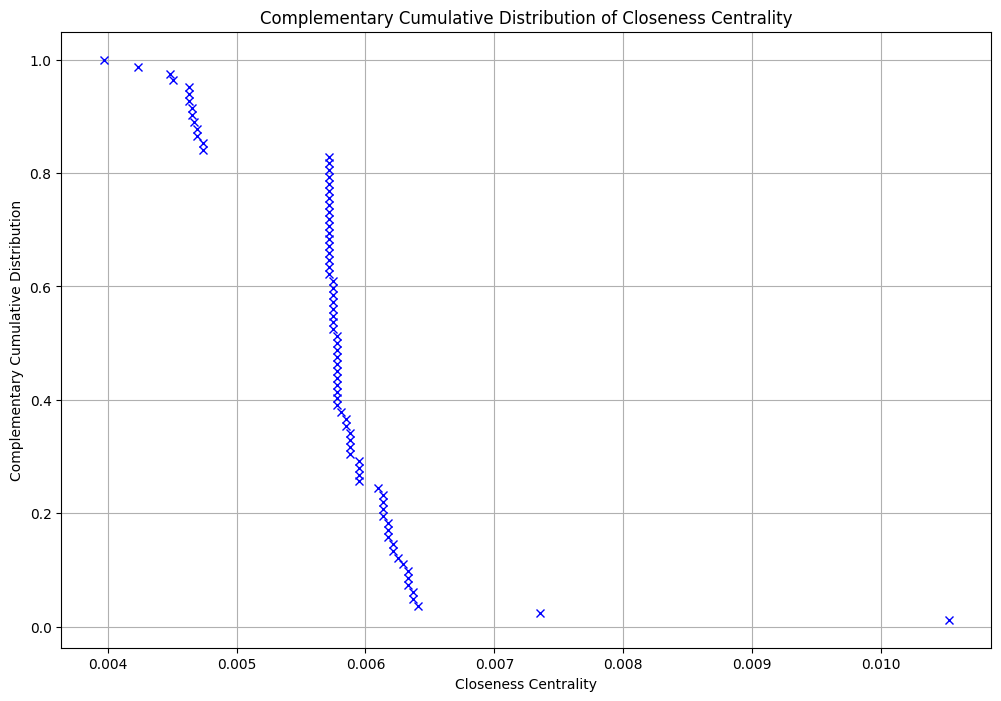

In [18]:
closeness_values = sorted(list(closeness_centrality_custom.values()))

ccdf_y = np.arange(1, len(closeness_values) + 1)[::-1] / len(closeness_values)
ccdf_x = closeness_values

plt.figure(figsize=(12,8))
plt.plot(ccdf_x, ccdf_y, "x", color='blue')
plt.xlabel('Closeness Centrality')
plt.ylabel('Complementary Cumulative Distribution')
plt.title('Complementary Cumulative Distribution of Closeness Centrality')
plt.grid(True, which="both")
plt.show()


<a id='week5'></a>
#WEEK 5 ANALYSIS#
  

**1) Write a function to compute the PageRank of the nodes in a graph (you are not allowed to
use built-in functions from NetworkX).**


**2) Run it on your graph using ff = 0.15, save the total number of iterations, and check that
your function returns the same results (in terms of the scores) as the built-in function from
NetworkX.**


**3) Identify the node with the highest PageRank, compare it with the one you got from week 3,
and give an interpretation to the possible difference.**


**4) Provide the cumulative distribution, compare it with the one you got from week 3, and
comment the results.**


**5) Optional: Re-run the PageRank using ff = 0.5, save the total number of iterations, compare
with the results (in terms of both the number of iterations and the cumulative distribution)
obtained for ff = 0.15, and comment.**

In [19]:
def compute_pagerank(G, alpha=0.15, max_iter=100, convergence=1e-6):
    N = len(G)
    if N == 0:
        return {}
    rank = {node: 1/N for node in G}
    
    out_links = {node: len(list(G.neighbors(node))) for node in G}
    
    for iteration in range(max_iter):
        new_rank = {}
        for node in G:
            rank_sum = sum(rank[neighbor] / out_links[neighbor] for neighbor in G.neighbors(node))
            new_rank[node] = (alpha/N) + (1-alpha) * rank_sum
        if all(abs(new_rank[node] - rank[node]) <= convergence for node in G):
            return new_rank, iteration + 1
        
        rank = new_rank
    
    return rank, max_iter

In [20]:
# Run the custom PageRank function with ff as 1 - alpha
pagerank, iterations = compute_pagerank(G, alpha=0.15)

# Run the built-in NetworkX PageRank function with alpha set to 0.85 (which is 1 - ff)
pagerank_nx = nx.pagerank(G, alpha=0.85)

print("Custom PageRank iterations:", iterations)
for node in sorted(pagerank):
    print(f"Node {node}: Custom PageRank = {pagerank[node]}, NetworkX PageRank = {pagerank_nx[node]}")

Custom PageRank iterations: 25
Node 0: Custom PageRank = 0.008367118354437642, NetworkX PageRank = 0.007013198294580523
Node 1: Custom PageRank = 0.02016086129753627, NetworkX PageRank = 0.022029554945055575
Node 2: Custom PageRank = 0.004390621342402146, NetworkX PageRank = 0.0038687075875165214
Node 3: Custom PageRank = 0.004390621342402146, NetworkX PageRank = 0.0038687075875165214
Node 4: Custom PageRank = 0.013613492289128457, NetworkX PageRank = 0.011796145442644228
Node 5: Custom PageRank = 0.004390621342402146, NetworkX PageRank = 0.0038687075875165214
Node 6: Custom PageRank = 0.014980808766163818, NetworkX PageRank = 0.01861803751313391
Node 7: Custom PageRank = 0.0072258950860248005, NetworkX PageRank = 0.0061226122011679394
Node 8: Custom PageRank = 0.007422137556727871, NetworkX PageRank = 0.006539989987060084
Node 9: Custom PageRank = 0.0052943046711472624, NetworkX PageRank = 0.004965196916165868
Node 10: Custom PageRank = 0.004109239059989309, NetworkX PageRank = 0.0037

# Highest node in PageRank #


In [21]:
highest_PR = max(pagerank, key=pagerank.get)
print('Highest PageRank:', highest_PR)

Highest PageRank: 22


comment it

In [22]:
pagerank_custom, iterations = compute_pagerank(G, alpha=0.50)
for node in sorted(pagerank):
    print(f"Node {node}: 0.15 Pagerank = {pagerank[node]}, 0.50 Pagerank = {pagerank_custom[node]}")


Node 0: 0.15 Pagerank = 0.008367118354437642, 0.50 Pagerank = 0.008946137098210582
Node 1: 0.15 Pagerank = 0.02016086129753627, 0.50 Pagerank = 0.01527145480102661
Node 2: 0.15 Pagerank = 0.004390621342402146, 0.50 Pagerank = 0.007250978954801748
Node 3: 0.15 Pagerank = 0.004390621342402146, 0.50 Pagerank = 0.007250978954801748
Node 4: 0.15 Pagerank = 0.013613492289128457, 0.50 Pagerank = 0.011764369248654639
Node 5: 0.15 Pagerank = 0.004390621342402146, 0.50 Pagerank = 0.007250978954801748
Node 6: 0.15 Pagerank = 0.014980808766163818, 0.50 Pagerank = 0.013616453410271089
Node 7: 0.15 Pagerank = 0.0072258950860248005, 0.50 Pagerank = 0.009086259121411925
Node 8: 0.15 Pagerank = 0.007422137556727871, 0.50 Pagerank = 0.009228518320646285
Node 9: 0.15 Pagerank = 0.0052943046711472624, 0.50 Pagerank = 0.008404708655427313
Node 10: 0.15 Pagerank = 0.004109239059989309, 0.50 Pagerank = 0.007081637424196441
Node 11: 0.15 Pagerank = 0.011400079382473999, 0.50 Pagerank = 0.010563142986209938
No

## Page Rank Cumulative Distribution ##

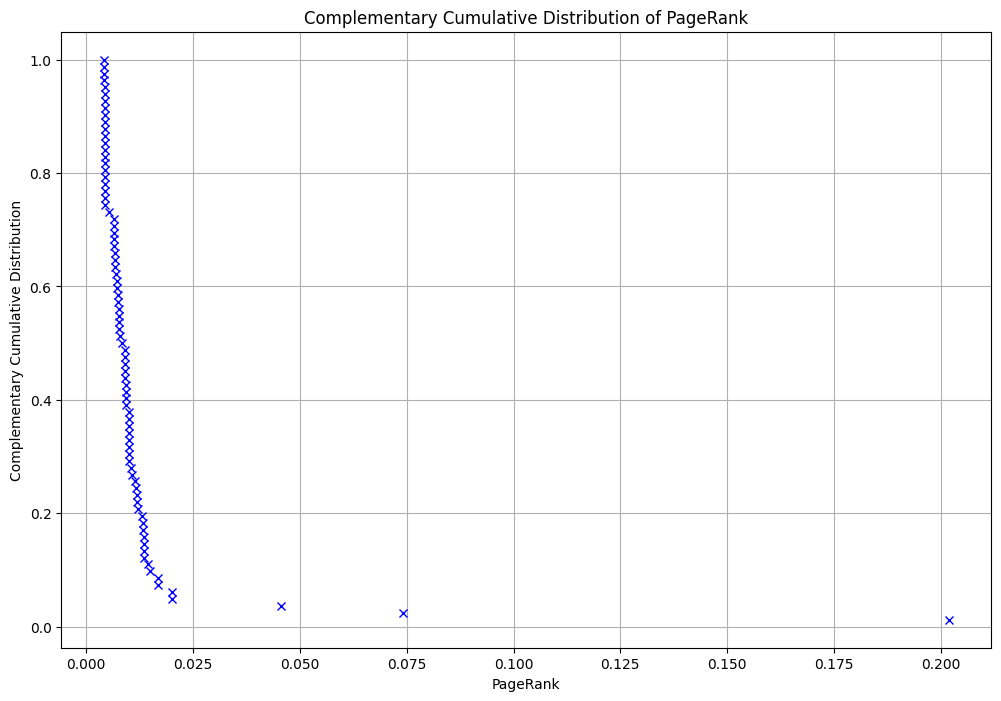

In [23]:
PR_values = sorted(list(pagerank.values()))

ccdf_y = np.arange(1, len(PR_values) + 1)[::-1] / len(PR_values)
ccdf_x = PR_values

plt.figure(figsize=(12,8))
plt.plot(ccdf_x, ccdf_y, "x", color='blue')
plt.xlabel('PageRank')
plt.ylabel('Complementary Cumulative Distribution')
plt.title('Complementary Cumulative Distribution of PageRank')
plt.grid(True, which="both")
plt.show()

## Page Rank Cumulative Distribution on alpha = 0.5 ##



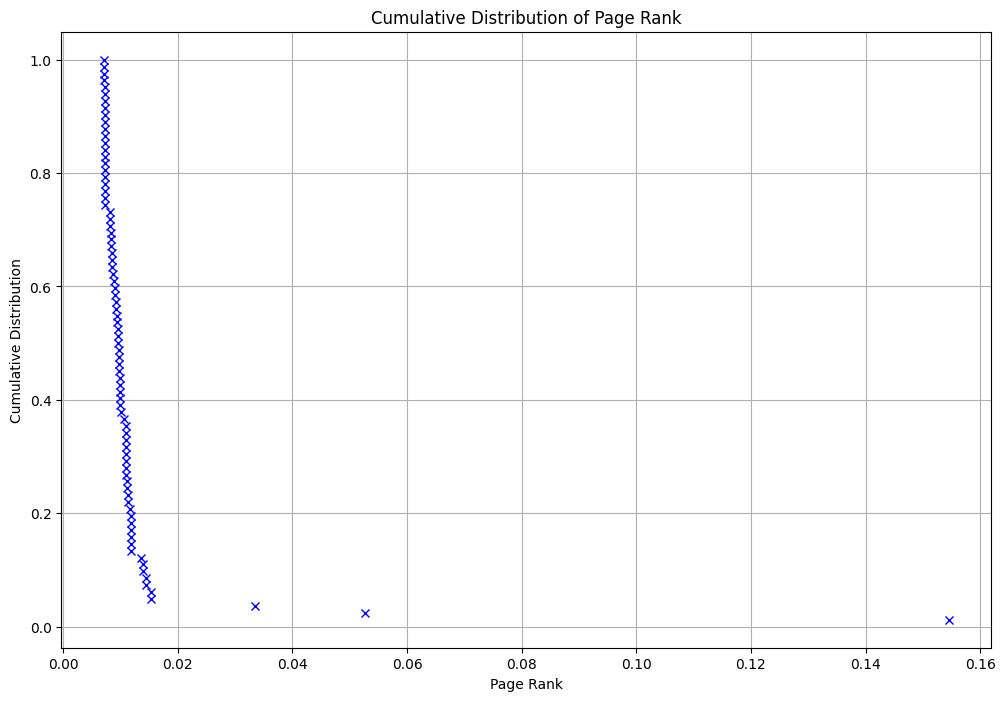

In [24]:
pagerank_values = sorted(list(pagerank_custom.values()))

ccdf_y = np.arange(1, len(pagerank_values) + 1)[::-1] / len(pagerank_values)
ccdf_x = pagerank_values

plt.figure(figsize=(12,8))
plt.plot(ccdf_x, ccdf_y, "x", color='blue')
plt.xlabel('Page Rank')
plt.ylabel('Cumulative Distribution')
plt.title('Cumulative Distribution of Page Rank')
plt.grid(True, which="both")
plt.show()

## WEEK 6 ANALYSIS ##

0) Treat your graph as undirected and unweighted. Delete loops and work on the resulting largest
connected component.

1) Implement the following three techniques for community detection:
a) Bridge removal (pick the partition with the highest modularity), b) Modularity optimization, c) Label
propagation.
In this case, you are allowed to use built-in functions from NetworkX.

2) Compare the results of each technique in terms of: a) number of detected clusters, b) cluster size distribution, c) computational time, e) modularity, f) other aspects you consider relevant, if any. Results should be presented in a table.

3) Give an interpretation to the differences and similarities between the three resulting partitions, and discuss which one you think is the best and why.

4) Provide a visualization for the partition you decided to be the best using Gephi.

5) Optional: for each pair of partitions compute the NMI between them and discuss.

In [25]:
def community_detection_bridge_removal(G):
    communities_generator = nx.community.girvan_newman(G)
    best_modularity = -1
    optimal_bridge = None
    for communities in communities_generator:
        partition = {node: idx for idx, community in enumerate(communities) for node in community}
        modularity = community.modularity(partition, G)
        if modularity > best_modularity:
            best_modularity = modularity
            edge_betweenness = nx.edge_betweenness_centrality(G)
            optimal_bridge = max(edge_betweenness, key=edge_betweenness.get)

    return optimal_bridge,best_modularity

In [26]:
G_undirected = nx.Graph(G)
for u, v, data in G_undirected.edges(data=True):
    data['weight'] = 1
G_undirected.remove_edges_from(nx.selfloop_edges(G_undirected))
largest_connected_c = max(nx.connected_components(G_undirected), key=len)
G_lcc = G_undirected.subgraph(largest_connected_c).copy()
optimal_bridge, max_modularity = community_detection_bridge_removal(G_lcc)
print("Bridge removal and Optimal bridge:", optimal_bridge)
G_lcc.remove_edge(*optimal_bridge)
partition = community.best_partition(G_lcc)
modularity = community.modularity(partition, G_lcc)
print("Modularity after bridge removal:", modularity)
communities = list(nx.algorithms.community.label_propagation.label_propagation_communities(G_lcc))
print("Label propagation communities:",communities)

Bridge removal and Optimal bridge: (22, 34)
Modularity after bridge removal: 0.4326800663554647
Label propagation communities: [{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 76, 77, 78, 79, 80, 81}, {72, 17, 28, 14}]


## Comparisons between different results ##

In [27]:
def community_detection_methods_analysis(G_undirected):
    # br = bridge removal, lou = louvain, lp = label propagation
    results = []
    # Bridge Removal
    start_time = time.time()
    optimal_bridge, br_modularity = community_detection_bridge_removal(G)
    G_br = G.copy()
    G_br.remove_edge(*optimal_bridge)
    br_communities = list(nx.connected_components(G_br))
    # just a simple subtraction to get the time taken
    br_time = time.time() - start_time
    # we are just finding the size of each community
    br_clusters_size = [len(c) for c in br_communities]
    results.append({
        "method": "Bridge Removal",
        "num_clusters": len(br_communities),
        "size_distribution": br_clusters_size,
        "time": br_time,
        "modularity": br_modularity
    })


    # Girvan Newman (Edge Betweenness)
    start_time = time.time()
    louvain_partition = community.best_partition(G)
    louvain_communities = {}
    # here we are just assigning the nodes to the communities
    for node, comm_id in louvain_partition.items():
        louvain_communities.setdefault(comm_id, []).append(node)
    # here we are just finding the modularity of the partition
    louvain_modularity = community.modularity(louvain_partition, G)
    # same as above just a simple subtraction to get the time taken
    lou_time = time.time() - start_time
    lou_clusters_size = [len(c) for c in louvain_communities.values()]
    results.append({
        "method": "Modularity Optimization (Louvain)",
        "num_clusters": len(louvain_communities),
        "size_distribution": lou_clusters_size,
        "time": lou_time,
        "modularity": louvain_modularity
    })

    # Label Propagation
    start_time = time.time()
    # here we are just finding the communities using the label propagation method
    label_propagation_communities = list(nx.algorithms.community.label_propagation.label_propagation_communities(G))
    lp_time = time.time() - start_time
    lp_clusters_size = [len(c) for c in label_propagation_communities]
    results.append({
        "method": "Label Propagation",
        "num_clusters": len(label_propagation_communities),
        "size_distribution": lp_clusters_size,
        "time": lp_time,
        "modularity": None  # Label Propagation doesn't directly optimize modularity
    })
    return results
results_table = community_detection_methods_analysis(G_undirected)
for result in results_table:
    print(f"Method: {result['method']}")
    print(f"Number of Clusters: {result['num_clusters']}")
    print(f"Size Distribution: {result['size_distribution']}")
    print(f"Computational Time: {result['time']:.4f} seconds")
    print(f"Modularity: {result['modularity']}")
    print("------------")


Method: Bridge Removal
Number of Clusters: 1
Size Distribution: [82]
Computational Time: 1.0252 seconds
Modularity: 0.34715
------------
Method: Modularity Optimization (Louvain)
Number of Clusters: 6
Size Distribution: [22, 35, 17, 3, 3, 2]
Computational Time: 0.0000 seconds
Modularity: 0.38771249999999996
------------
Method: Label Propagation
Number of Clusters: 2
Size Distribution: [17, 65]
Computational Time: 0.0080 seconds
Modularity: None
------------


In [28]:
label_propagation_communities = list(nx.algorithms.community.label_propagation.label_propagation_communities(G))
# Create a map of node to community
community_map = {}
for community_id, community in enumerate(label_propagation_communities):
    for node in community:
        community_map[node] = community_id
nx.set_node_attributes(G_undirected, community_map, 'community')

# Export to GEXF
nx.write_gexf(G_undirected,'graph1.gexf')

In [ ]:
# NMI computation using a function of sklearn, analysing all the pairs of communities that we found with the previous methods

from sklearn.metrics.cluster import normalized_mutual_info_score

nmi_score_1 = normalized_mutual_info_score(br_communities, louvain_communities.values())  #this because louvain_communities is a dict (At least I guess)
print(f"NMI Score between 'bridge removal communities' and 'louvain_communities': {nmi_score_1}")

nmi_score_2 = normalized_mutual_info_score(br_communities, label_propagation_communities)
print(f"NMI Score between 'bridge removal communities' and 'label propagation communities': {nmi_score_2}")

nmi_score_3 = normalized_mutual_info_score(label_propagation_communities, louvain_communities.values())
print(f"NMI Score between 'label propagation communities' and 'louvain_communities': {nmi_score_3}"

## WEEK 7 ANALYSIS ##

0) Treat your graph as undirected and unweighted, and work on the resulting largest connected
component. Delete loops

1) Create a function computing CN and one of the topological indices between JI,PA,AA,RA.
Your function should return a pandaframe where each row is a missing link and each column is
an index. You are allowed to use built-in functions from NetworkX for computing individual
indices.

2) Create a third score by adding a column with the arithmetic mean between the two indices.
[NB: the arithmetic mean should be computed after rescaling each column between 0 and 1.]

3) For each of the 3 scores, identify as missing links the node pairs yielding the largest 5 values.
Briefly comment the results.

4) Optional: Invent a new index/score and compare the result

## Link Prediction functions ##

* computation of the CN
* computation of the Jaccard Index


In [29]:
# Treating the graph as undirected unweighted
G_undirected = nx.Graph(G)
# here we are just assigning a weight of 1 to each edge
for u, v, data in G_undirected.edges(data=True):
    data['weight'] = 1
# here we are just removing self loops
G_undirected.remove_edges_from(nx.selfloop_edges(G_undirected))
def common_neighbor_index(G_undirected):
    common_neighbors = {}

    processed_pairs = set()

    for node1 in G_undirected.nodes():
        for node2 in G_undirected.nodes():
            if node1 != node2 and not G.has_edge(node1, node2) and (node2, node1) not in processed_pairs :
                neighbors1 = set(G_undirected.neighbors(node1))
                neighbors2 = set(G_undirected.neighbors(node2))

                common_neighbors[(node1, node2)] = len(neighbors1.intersection(neighbors2))

                processed_pairs.add((node1, node2))


    return common_neighbors

result = common_neighbor_index(G_undirected)



print("Common Neighbors: ", result)


Common Neighbors:  {(0, 2): 0, (0, 3): 0, (0, 4): 0, (0, 5): 0, (0, 6): 1, (0, 7): 0, (0, 8): 0, (0, 9): 0, (0, 10): 0, (0, 11): 1, (0, 12): 0, (0, 13): 0, (0, 14): 1, (0, 15): 0, (0, 16): 0, (0, 17): 1, (0, 18): 1, (0, 19): 1, (0, 21): 1, (0, 22): 3, (0, 23): 0, (0, 24): 0, (0, 25): 0, (0, 26): 0, (0, 27): 1, (0, 28): 1, (0, 29): 1, (0, 30): 0, (0, 31): 0, (0, 32): 1, (0, 33): 3, (0, 35): 1, (0, 36): 1, (0, 37): 0, (0, 38): 0, (0, 39): 1, (0, 40): 1, (0, 41): 0, (0, 42): 0, (0, 43): 0, (0, 44): 0, (0, 45): 0, (0, 46): 0, (0, 47): 0, (0, 48): 0, (0, 49): 0, (0, 50): 0, (0, 51): 3, (0, 52): 0, (0, 53): 0, (0, 54): 0, (0, 55): 1, (0, 56): 0, (0, 57): 0, (0, 58): 1, (0, 59): 0, (0, 60): 0, (0, 61): 0, (0, 62): 0, (0, 63): 0, (0, 64): 0, (0, 65): 0, (0, 66): 3, (0, 67): 0, (0, 68): 1, (0, 69): 0, (0, 70): 3, (0, 71): 1, (0, 72): 1, (0, 73): 0, (0, 74): 0, (0, 75): 0, (0, 76): 0, (0, 77): 0, (0, 78): 0, (0, 79): 0, (0, 80): 0, (0, 81): 0, (1, 2): 1, (1, 3): 1, (1, 4): 1, (1, 5): 1, (1, 6): 

In [30]:
ji = list(nx.jaccard_coefficient(G))
print("Jaccard index: ",ji)

Jaccard index:  [(0, 2, 0.0), (0, 3, 0.0), (0, 4, 0.0), (0, 5, 0.0), (0, 6, 0.14285714285714285), (0, 7, 0.0), (0, 8, 0.0), (0, 9, 0.0), (0, 10, 0.0), (0, 11, 0.16666666666666666), (0, 12, 0.0), (0, 13, 0.0), (0, 14, 0.25), (0, 15, 0.0), (0, 16, 0.0), (0, 17, 0.2), (0, 18, 0.2), (0, 19, 0.2), (0, 21, 0.125), (0, 22, 0.04477611940298507), (0, 23, 0.0), (0, 24, 0.0), (0, 25, 0.0), (0, 26, 0.0), (0, 27, 0.16666666666666666), (0, 28, 0.16666666666666666), (0, 29, 0.2), (0, 30, 0.0), (0, 31, 0.0), (0, 32, 0.25), (0, 33, 0.6), (0, 35, 0.2), (0, 36, 0.16666666666666666), (0, 37, 0.0), (0, 38, 0.0), (0, 39, 0.25), (0, 40, 0.3333333333333333), (0, 41, 0.0), (0, 42, 0.0), (0, 43, 0.0), (0, 44, 0.0), (0, 45, 0.0), (0, 46, 0.0), (0, 47, 0.0), (0, 48, 0.0), (0, 49, 0.0), (0, 50, 0.0), (0, 51, 0.75), (0, 52, 0.0), (0, 53, 0.0), (0, 54, 0.0), (0, 55, 0.3333333333333333), (0, 56, 0.0), (0, 57, 0.0), (0, 58, 0.125), (0, 59, 0.0), (0, 60, 0.0), (0, 61, 0.0), (0, 62, 0.0), (0, 63, 0.0), (0, 64, 0.0), (0,

In [31]:
def ArithmeticMean(ji, result):
    results = []

    for node1, node2, ji_value in ji:
        # Get the corresponding value from the result dictionary
        result_value = result.get((node1, node2), 0)

        # Calculate the arithmetic mean for the current tuple
        mean_value = (ji_value + result_value) / 2

        # Append the mean value to the results list
        results.append(mean_value)
    # normalizing the results
    max_value = max(results)
    results = [value / max_value for value in results]

    return results

print(ArithmeticMean(ji, result))


[0.0, 0.0, 0.0, 0.0, 0.2229965156794425, 0.0, 0.0, 0.0, 0.0, 0.22764227642276424, 0.0, 0.0, 0.24390243902439024, 0.0, 0.0, 0.23414634146341462, 0.23414634146341462, 0.23414634146341462, 0.21951219512195122, 0.5941026574444849, 0.0, 0.0, 0.0, 0.0, 0.22764227642276424, 0.22764227642276424, 0.23414634146341462, 0.0, 0.0, 0.24390243902439024, 0.702439024390244, 0.23414634146341462, 0.22764227642276424, 0.0, 0.0, 0.24390243902439024, 0.26016260162601623, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7317073170731707, 0.0, 0.0, 0.0, 0.26016260162601623, 0.0, 0.0, 0.21951219512195122, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.702439024390244, 0.0, 0.26016260162601623, 0.0, 0.702439024390244, 0.23414634146341462, 0.2229965156794425, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.21951219512195122, 0.21951219512195122, 0.2113821138211382, 0.21951219512195122, 0.425720620842572, 0.21680216802168023, 0.21680216802168023, 0.0, 0.0, 0.4292682926829269, 0.21463414634146344, 0.21463414634146344, 0.2

In [32]:
df = pd.DataFrame(ji, columns=['Node1', 'Node2', 'Jaccard Index'])
df['Common Neighbors'] = result.values()
df['Arithmetic Mean'] = ArithmeticMean(ji, result)
print(df)

      Node1  Node2  Jaccard Index  Common Neighbors  Arithmetic Mean
0         0      2       0.000000                 0         0.000000
1         0      3       0.000000                 0         0.000000
2         0      4       0.000000                 0         0.000000
3         0      5       0.000000                 0         0.000000
4         0      6       0.142857                 1         0.222997
...     ...    ...            ...               ...              ...
3154     78     81       0.500000                 1         0.292683
3155     78     79       0.500000                 1         0.292683
3156     79     80       0.500000                 1         0.292683
3157     79     81       0.333333                 1         0.260163
3158     80     81       0.500000                 1         0.292683

[3159 rows x 5 columns]


## Missing Links (Greatest 5 values) ##

In [33]:
top_5_rows = df.nlargest(5, 'Arithmetic Mean')
print("Top 5 rows:")
print(top_5_rows)

Top 5 rows:
      Node1  Node2  Jaccard Index  Common Neighbors  Arithmetic Mean
1561     24     34       0.125000                 5         1.000000
2040     33     66       0.666667                 4         0.910569
2044     33     70       0.666667                 4         0.910569
3043     66     70       0.666667                 4         0.910569
1492     22     51       0.059701                 1         0.792137


* Here, considering the **Arithmetic Mean index** , we see that the missing links are: (24,34); (33,66); (33,70); (66, 70); (22,51)

In [34]:
top_5_rows = df.nlargest(5, 'Common Neighbors')
print("Top 5 rows:")
print(top_5_rows)

Top 5 rows:
      Node1  Node2  Jaccard Index  Common Neighbors  Arithmetic Mean
1561     24     34       0.125000                 5         1.000000
1491     22     72       0.028571                 4         0.395819
2040     33     66       0.666667                 4         0.910569
2044     33     70       0.666667                 4         0.910569
3043     66     70       0.666667                 4         0.910569


* Here, considering the **Common Neighbor index**, we find out that the missing links are: (24,34); (22,72); (33,66); (33,70); (66,70)

In [35]:
top_5_rows = df.nlargest(5, 'Jaccard Index')
print("Top 5 rows:")
print(top_5_rows)

Top 5 rows:
     Node1  Node2  Jaccard Index  Common Neighbors  Arithmetic Mean
151      2      3            1.0                 1         0.390244
153      2      5            1.0                 1         0.390244
173      2     26            1.0                 1         0.390244
178      2     31            1.0                 1         0.390244
184      2     37            1.0                 1         0.390244


* Here, considering the **Jaccard Index**, we can see that the missing links are: (2,3); (2,5); (2,26); (2,31); (2,37)

## Average Degree

In [36]:
total_deg= sum(span for n, span in G.degree())
k=total_deg/(G.number_of_nodes())
## rounding to the closest integer since we have to use it as a parameter for the PA function
k = int(k)
print('The average degree is:')
print(k)


The average degree is:
3


#### Preferential attachment and Preferential attachment with m == m_closest_to_k

In [44]:
m_closest_to_k = k
num_nodes = G.number_of_nodes()
def PA(num_nodes, m, n_stage):
    G_new = nx.Graph()
    G_new.add_node(0)
    for i in range(1, num_nodes):
        new_node = i
        G_new.add_node(new_node)
        if len(G_new) > 1:
            sum_degree = sum(dict(G_new.degree()).values())
            if sum_degree == 0:
                G_new.add_edge(new_node, random.choice(list(G_new.nodes())))
            else:
                probs = [degree / sum_degree for node, degree in G_new.degree()]
                nodes_to_be_connected = random.choices(list(G_new.nodes), weights=probs, k=min(m, len(G_new)))
                for node in nodes_to_be_connected:
                    G_new.add_edge(new_node, node)
        if i >= n_stage:
            break

    return G_new

           

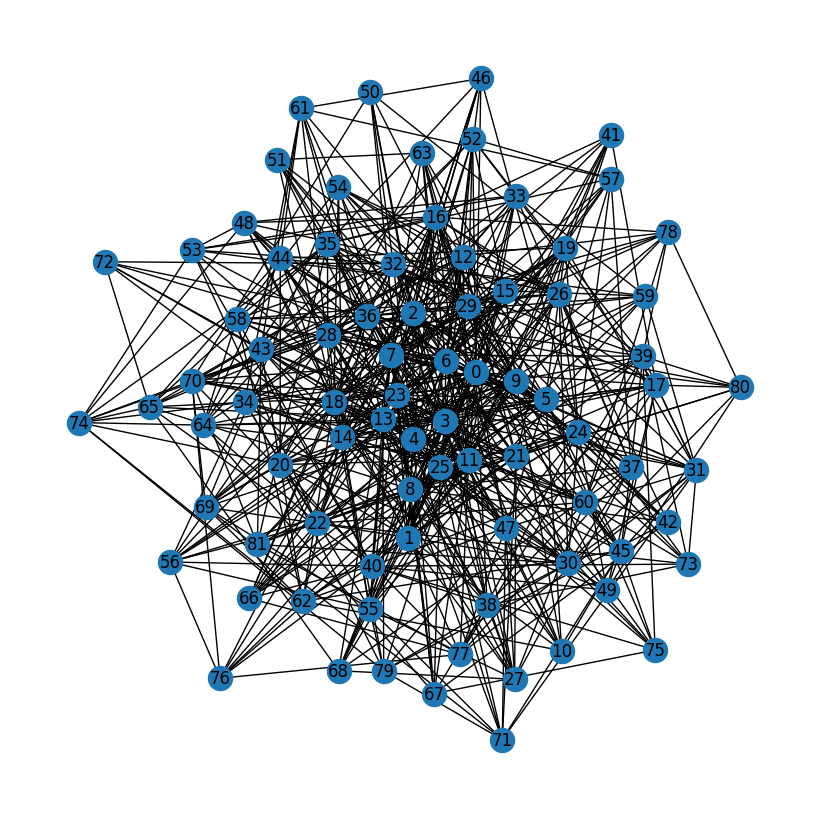

In [64]:
seed = random.seed(42)
G_1 = PA(num_nodes, 10, 1000)
pos = nx.spring_layout(G_1, seed=seed)
plt.figure(figsize=(8, 8))
nx.draw(G_1,pos, with_labels=True)
plt.show()

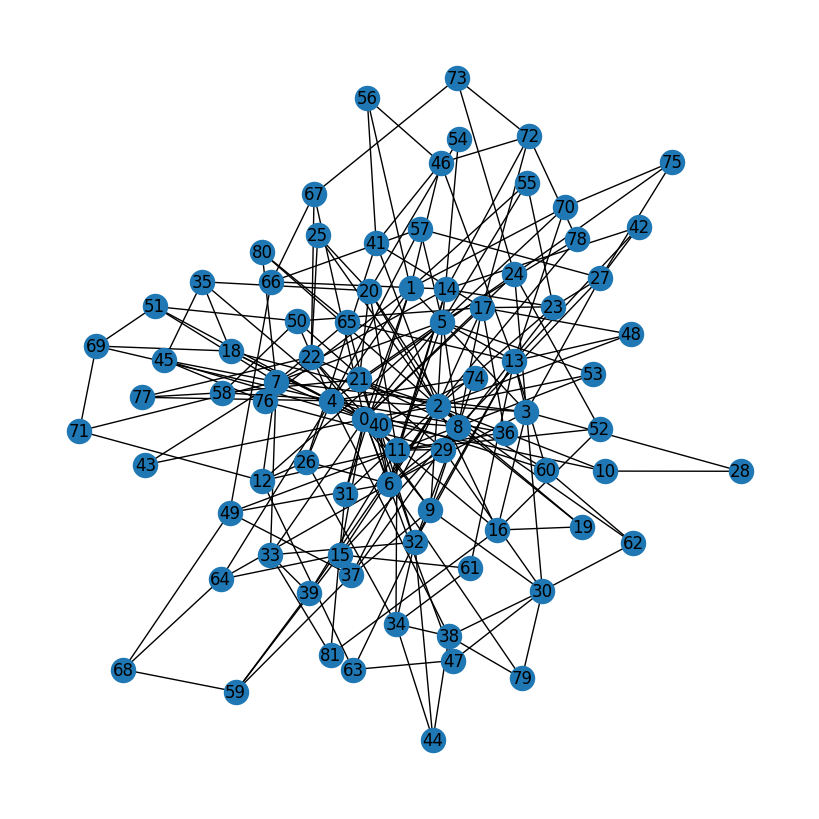

In [57]:
seed = random.seed(42)
G_2 = PA(num_nodes, m_closest_to_k, 1000)
pos = nx.spring_layout(G_2, seed=seed)
plt.figure(figsize=(8, 8))
nx.draw(G_2,pos, with_labels=True)
plt.show()

#### Comparison of G_1 (PA with normal m value) , G_2 (with a m value equal to the average degree)
  ##### Metrics used: 
  ##### Average clustering, Degree, Distributions, Transitivity, Average distance from one node, Diameter

In [65]:
triangles_in_graph_1 = total_triangles(G_1)
custom_trans_from_triangles_1 = custom_transitivity_from_triangles(G_1, triangles_in_graph_1)
print("transitivity from G_1:",custom_trans_from_triangles_1)
print(triangles_in_graph_1)
triangles_in_graph_2 = total_triangles(G_2)
custom_trans_from_triangles_2 = custom_transitivity_from_triangles(G_2, triangles_in_graph_2)
print("transitivity from G_2:",custom_trans_from_triangles_2)
print(triangles_in_graph_2)

avg_clustering_custom_1 = avg_clustering(G_1)
print("average clustering from G_1:",avg_clustering_custom_1)
avg_clustering_custom_2 = avg_clustering(G_2)
print("average clustering from G_2:",avg_clustering_custom_2)



def find_diameter(G):
    try:
        all_unweighted_shortest_path_lengths = {node: dijkstra_generic(G, node, use_weights=False)
                                            for node in G.nodes()}
        diameter = max(max(distances.values()) for distances in all_unweighted_shortest_path_lengths.values())
        return diameter
    except:
        return float('inf')

diameter_1 = find_diameter(G_1)
diameter_2 = find_diameter(G_2)

print("Diameter for G_1:", diameter_1)
print("Diameter for G_2:", diameter_2)

triangles_in_graph_1 = total_triangles(G_1)
custom_trans_from_triangles_1 = custom_transitivity_from_triangles(G_1, triangles_in_graph_1)
print("transitivity from G_1:",custom_trans_from_triangles_1)
print(triangles_in_graph_1)
triangles_in_graph_2 = total_triangles(G_2)
custom_trans_from_triangles_2 = custom_transitivity_from_triangles(G_2, triangles_in_graph_2)
print("transitivity from G_2:",custom_trans_from_triangles_2)
print(triangles_in_graph_2)

avg_clustering_custom_1 = avg_clustering(G_1)
print("average clustering from G_1:",avg_clustering_custom_1)
avg_clustering_custom_2 = avg_clustering(G_2)
print("average clustering from G_2:",avg_clustering_custom_2)



def find_diameter(G):
    try:
        all_unweighted_shortest_path_lengths = {node: dijkstra_generic(G, node, use_weights=False)
                                            for node in G.nodes()}
        diameter = max(max(distances.values()) for distances in all_unweighted_shortest_path_lengths.values())
        return diameter
    except:
        return float('inf')

diameter_1 = find_diameter(G_1)
diameter_2 = find_diameter(G_2)

print("Diameter for G_1:", diameter_1)
print("Diameter for G_2:", diameter_2)

def degree_distribution(G):
    degree_dict = dict(G.degree())
    degree_values = sorted(set(degree_dict.values()))
    histogram = [list(degree_dict.values()).count(i)/float(nx.number_of_nodes(G)) for i in degree_values]
    return histogram
degree_dist_1 = degree_distribution(G_1)
degree_dist_2 = degree_distribution(G_2)

print("Degree distribution for G_1:", degree_dist_1)
print("Degree distribution for G_2:", degree_dist_2)


def average_shortest_path_length(G, all_shortest_path_lengths):
    total_length = 0
    count = 0
    for source_node, shortest_paths in all_shortest_path_lengths.items():
        for target_node, length in shortest_paths.items():
            if source_node != target_node:
                total_length += length
                count += 1
    return total_length / count if count > 0 else 0


all_unweighted_shortest_path_lengths_G_1 = {node: dijkstra_generic(G_1, node, use_weights=False) for node in G_1.nodes()}
avg_path_length_unweighted_G_1 = average_shortest_path_length(G_1, all_unweighted_shortest_path_lengths_G_1)
all_unweighted_shortest_path_lengths_G_2 = {node: dijkstra_generic(G_2, node, use_weights=False) for node in G_2.nodes()}
avg_path_length_unweighted_G_2 = average_shortest_path_length(G_2, all_unweighted_shortest_path_lengths_G_2)
print("Average shortest path length for G_1:", avg_path_length_unweighted_G_1)
print("Average shortest path length for G_2:", avg_path_length_unweighted_G_2)




closeness_centrality_custom_1 = custom_closeness_centrality(G_1, all_unweighted_shortest_path_lengths_G_1)
most_central_character_1 = max(closeness_centrality_custom_1, key=closeness_centrality_custom_1.get)
print('Most central character in G_1:', most_central_character_1)
print('Closeness centrality in G_1:', closeness_centrality_custom_1[most_central_character_1])
closeness_centrality_custom_2 = custom_closeness_centrality(G_2, all_unweighted_shortest_path_lengths_G_2)
most_central_character_2 = max(closeness_centrality_custom_2, key=closeness_centrality_custom_2.get)
print('Most central character in G_2:', most_central_character_2)
print('Closeness centrality in G_2:', closeness_centrality_custom_2[most_central_character_2])



transitivity from G_1: 0.25077802706810454
1155
transitivity from G_2: 0.0743801652892562
54
average clustering from G_1: 0.3044505723149239
average clustering from G_2: 0.14469652512656364
Diameter for G_1: 3.0
Diameter for G_2: 4.0
transitivity from G_1: 0.25077802706810454
1155
transitivity from G_2: 0.0743801652892562
54
average clustering from G_1: 0.3044505723149239
average clustering from G_2: 0.14469652512656364
Diameter for G_1: 3.0
Diameter for G_2: 4.0
Degree distribution for G_1: [0.024390243902439025, 0.012195121951219513, 0.0975609756097561, 0.14634146341463414, 0.08536585365853659, 0.07317073170731707, 0.06097560975609756, 0.012195121951219513, 0.07317073170731707, 0.04878048780487805, 0.036585365853658534, 0.036585365853658534, 0.04878048780487805, 0.012195121951219513, 0.036585365853658534, 0.024390243902439025, 0.012195121951219513, 0.04878048780487805, 0.012195121951219513, 0.012195121951219513, 0.012195121951219513, 0.012195121951219513, 0.024390243902439025, 0.0121

## Independet Cascade Model

In [41]:
def independent_cascade_model(G, initial_active, activation_prob):
    active = set(initial_active)
    newly_active = set(initial_active)
    while newly_active:
        next_active = set()
        for node in newly_active:
            neighbors = set(G.neighbors(node)) - active
            for neighbor in neighbors:
                edge_weight = G[node][neighbor]['weight']
                if random.random() < activation_prob(edge_weight):
                    next_active.add(neighbor)

        newly_active = next_active
        active.update(newly_active)

    return active
initial_active = random.sample(G.nodes(), 10)
activation_prob = lambda weight: min(0.1 * weight, 1)

final_active_set = independent_cascade_model(G, initial_active, activation_prob)
print("Final set of active nodes:", final_active_set)

Final set of active nodes: {64, 1, 66, 4, 70, 6, 72, 12, 78, 15, 18, 20, 21, 22, 24, 27, 28, 34, 36, 42, 47, 50, 51, 52, 53, 54, 55, 57}


C:\Users\david\AppData\Local\Temp\ipykernel_30252\2701286033.py:17: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  initial_active = random.sample(G.nodes(), 10)


##### This model could simulate a scenario where an actor influences others with whom they share scenes. For instance, this could represent the spread of a new acting technique or a piece of gossip. The more frequently actors share scenes (higher edge weight), the higher the probability could be for one actor to influence another.

### Considerations of different scenarios

In [42]:
def run_experiment(G, initial_active_func, activation_prob_func, num_experiments=1):
    results = []
    for _ in range(num_experiments):
        initial_active = initial_active_func(G)
        final_active_set = independent_cascade_model(G, initial_active, activation_prob_func)
        results.append(final_active_set)
    return results
small_outbreak_results = run_experiment(
    G, 
    lambda G: random.sample(list(G.nodes()), 5),
    lambda weight: min(0.1 * weight, 1),
    num_experiments=10
)
large_outbreak_results = run_experiment(
    G, 
    lambda G: random.sample(list(G.nodes()), 20),  
    lambda weight: min(0.1 * weight, 1),
    num_experiments=10
)
strategic_origin_results = run_experiment(
    G,
    lambda G: [node for node, _ in sorted(nx.degree_centrality(G).items(), key=lambda x: x[1], reverse=True)[:10]], # Top 10 central nodes
    lambda weight: min(0.1 * weight, 1),
    num_experiments=10
)


def print_results(experiment_results, experiment_name):
    print(f"Results for {experiment_name}:")
    for i, active_set in enumerate(experiment_results, 1):
        print(f"  Run {i}: {len(active_set)} nodes activated")
    print()
print_results(small_outbreak_results, "Small Outbreak")
print_results(large_outbreak_results, "Large Outbreak")
print_results(strategic_origin_results, "Strategic Origin with Top 10 Central Nodes")

Results for Small Outbreak:
  Run 1: 5 nodes activated
  Run 2: 26 nodes activated
  Run 3: 29 nodes activated
  Run 4: 5 nodes activated
  Run 5: 20 nodes activated
  Run 6: 20 nodes activated
  Run 7: 5 nodes activated
  Run 8: 6 nodes activated
  Run 9: 30 nodes activated
  Run 10: 5 nodes activated

Results for Large Outbreak:
  Run 1: 35 nodes activated
  Run 2: 35 nodes activated
  Run 3: 40 nodes activated
  Run 4: 38 nodes activated
  Run 5: 35 nodes activated
  Run 6: 33 nodes activated
  Run 7: 26 nodes activated
  Run 8: 29 nodes activated
  Run 9: 34 nodes activated
  Run 10: 36 nodes activated

Results for Strategic Origin with Top 10 Central Nodes:
  Run 1: 18 nodes activated
  Run 2: 18 nodes activated
  Run 3: 26 nodes activated
  Run 4: 21 nodes activated
  Run 5: 20 nodes activated
  Run 6: 25 nodes activated
  Run 7: 25 nodes activated
  Run 8: 23 nodes activated
  Run 9: 23 nodes activated
  Run 10: 25 nodes activated



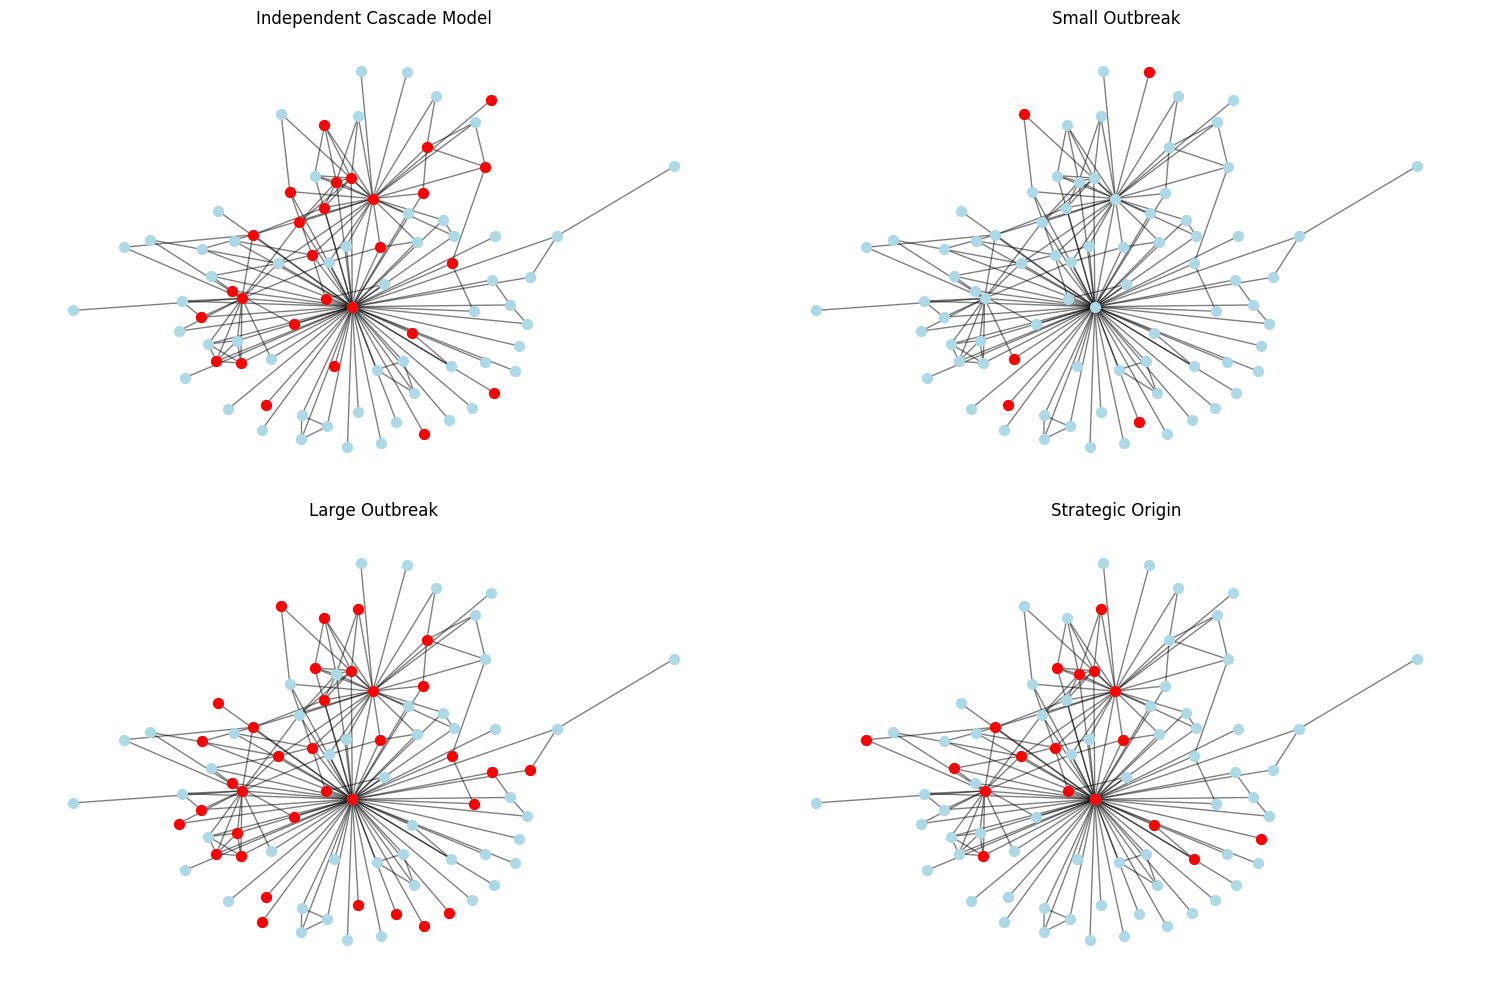

In [43]:
def visualize_network_subplot(G, active_nodes, pos, ax, title):
    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=50, node_color='lightblue')
    nx.draw_networkx_nodes(G, pos, nodelist=active_nodes, node_color='r', node_size=50, ax=ax)
    nx.draw_networkx_edges(G, pos, ax=ax, alpha=0.5)
    ax.set_title(title)
    ax.axis("off")
pos = nx.spring_layout(G)  
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
visualize_network_subplot(G, final_active_set, pos, axs[0, 0], "Independent Cascade Model")
visualize_network_subplot(G, small_outbreak_results[0], pos, axs[0, 1], "Small Outbreak")
visualize_network_subplot(G, large_outbreak_results[0], pos, axs[1, 0], "Large Outbreak")
visualize_network_subplot(G, strategic_origin_results[0], pos, axs[1, 1], "Strategic Origin")

plt.tight_layout()
plt.show()